In [1]:
from pyspark.sql import SparkSession

In [2]:
spark = SparkSession.builder \
   .master("local") \
   .appName("Predicting Fire Dept Calls") \
   .config("spark.executor.memory", "6gb") \
   .getOrCreate()

In [3]:
df = spark.read.format('com.databricks.spark.csv')\
                    .options(header='true', inferschema='true')\
                    .load('Fire_Department_Calls_for_Service.csv')


In [4]:
df.show(2)

+-----------+-------+---------------+----------------+----------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------------------+--------------------+--------------------+----+-------------------+---------+------------+----+-----------------+--------+--------------+--------+---------------+----------------+---------+------------------------------+------------------------+-------------------+------------------------------------+--------------------+-------------+
|Call Number|Unit ID|Incident Number|       Call Type| Call Date|Watch Date|       Received DtTm|          Entry DtTm|       Dispatch DtTm|       Response DtTm|       On Scene DtTm|      Transport DtTm|       Hospital DtTm|Call Final Disposition|      Available DtTm|             Address|City|Zipcode of Incident|Battalion|Station Area| Box|Original Priority|Priority|Final Priority|ALS Unit|Call Type Group|Number o

In [5]:
df.select('Call Type Group').distinct().show()

+--------------------+
|     Call Type Group|
+--------------------+
|               Alarm|
|                null|
|Potentially Life-...|
|Non Life-threatening|
|                Fire|
+--------------------+



In [6]:
df.groupBy('Call Type Group').count().show()

+--------------------+-------+
|     Call Type Group|  count|
+--------------------+-------+
|               Alarm| 429831|
|                null|2804459|
|Potentially Life-...| 874195|
|Non Life-threatening| 414806|
|                Fire|  75797|
+--------------------+-------+



In [7]:
df2 = df.groupBy('Call Type Group').count()

In [8]:
graphDF = df2.toPandas()
graphDF = graphDF.sort_values('count', ascending=False)

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

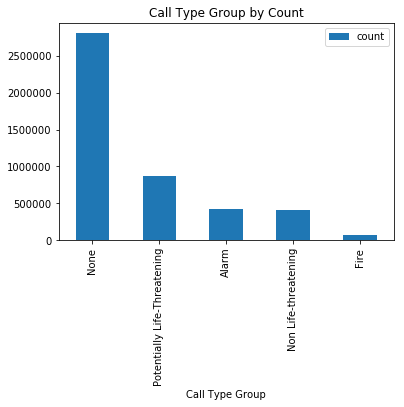

In [10]:
graphDF.plot(x='Call Type Group', y = 'count', kind='bar')
plt.title('Call Type Group by Count')
plt.show()

In [11]:
df.groupBy('Call Type').count().orderBy('count', ascending=False).show(100)

+--------------------+-------+
|           Call Type|  count|
+--------------------+-------+
|    Medical Incident|2979993|
|      Structure Fire| 609473|
|              Alarms| 491741|
|   Traffic Collision| 188097|
|               Other|  74038|
|Citizen Assist / ...|  69549|
|        Outside Fire|  53682|
|        Vehicle Fire|  22492|
|        Water Rescue|  21861|
|Gas Leak (Natural...|  17147|
|   Electrical Hazard|  12845|
|Odor (Strange / U...|  12339|
|Elevator / Escala...|  12028|
|Smoke Investigati...|  10118|
|          Fuel Spill|   5386|
|              HazMat|   3839|
|Industrial Accidents|   2803|
|           Explosion|   2530|
|  Aircraft Emergency|   1511|
|       Assist Police|   1318|
|Train / Rail Inci...|   1224|
|   High Angle Rescue|   1154|
|Watercraft in Dis...|    884|
|Extrication / Ent...|    672|
|           Oil Spill|    516|
|Confined Space / ...|    467|
|Mutual Aid / Assi...|    423|
|         Marine Fire|    359|
|  Suspicious Package|    314|
|      A

In [12]:
from pyspark.sql import functions as F
fireIndicator = df.select(df["Call Type"],F.when(df["Call Type"].like("%Fire%"),1).otherwise(0))
fireIndicator = fireIndicator.\
                withColumnRenamed('CASE WHEN Call Type LIKE %Fire% THEN 1 ELSE 0 END', 'Fire Indicator')
fireIndicator.show()

+--------------------+--------------+
|           Call Type|Fire Indicator|
+--------------------+--------------+
|    Medical Incident|             0|
|    Medical Incident|             0|
|    Medical Incident|             0|
|              Alarms|             0|
|    Medical Incident|             0|
|Citizen Assist / ...|             0|
|   Electrical Hazard|             0|
|Odor (Strange / U...|             0|
|    Medical Incident|             0|
|    Medical Incident|             0|
|              Alarms|             0|
|    Medical Incident|             0|
|    Medical Incident|             0|
|    Medical Incident|             0|
|              Alarms|             0|
|              Alarms|             0|
|    Medical Incident|             0|
|               Other|             0|
|    Medical Incident|             0|
|      Structure Fire|             1|
+--------------------+--------------+
only showing top 20 rows



In [13]:
fireIndicator.groupBy('Fire Indicator').count().show()

+--------------+-------+
|Fire Indicator|  count|
+--------------+-------+
|             1| 686016|
|             0|3913072|
+--------------+-------+



In [14]:
df = df.withColumn("fireIndicator", F.when(df["Call Type"].like("%Fire%"),1).otherwise(0))

In [15]:
df.printSchema()

root
 |-- Call Number: integer (nullable = true)
 |-- Unit ID: string (nullable = true)
 |-- Incident Number: integer (nullable = true)
 |-- Call Type: string (nullable = true)
 |-- Call Date: string (nullable = true)
 |-- Watch Date: string (nullable = true)
 |-- Received DtTm: string (nullable = true)
 |-- Entry DtTm: string (nullable = true)
 |-- Dispatch DtTm: string (nullable = true)
 |-- Response DtTm: string (nullable = true)
 |-- On Scene DtTm: string (nullable = true)
 |-- Transport DtTm: string (nullable = true)
 |-- Hospital DtTm: string (nullable = true)
 |-- Call Final Disposition: string (nullable = true)
 |-- Available DtTm: string (nullable = true)
 |-- Address: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Zipcode of Incident: integer (nullable = true)
 |-- Battalion: string (nullable = true)
 |-- Station Area: string (nullable = true)
 |-- Box: string (nullable = true)
 |-- Original Priority: string (nullable = true)
 |-- Priority: string (nullable

In [16]:
df.select('Call Type', 'fireIndicator').show(20)

+--------------------+-------------+
|           Call Type|fireIndicator|
+--------------------+-------------+
|    Medical Incident|            0|
|    Medical Incident|            0|
|    Medical Incident|            0|
|              Alarms|            0|
|    Medical Incident|            0|
|Citizen Assist / ...|            0|
|   Electrical Hazard|            0|
|Odor (Strange / U...|            0|
|    Medical Incident|            0|
|    Medical Incident|            0|
|              Alarms|            0|
|    Medical Incident|            0|
|    Medical Incident|            0|
|    Medical Incident|            0|
|              Alarms|            0|
|              Alarms|            0|
|    Medical Incident|            0|
|               Other|            0|
|    Medical Incident|            0|
|      Structure Fire|            1|
+--------------------+-------------+
only showing top 20 rows



In [17]:
df = df.select('fireIndicator', 
               'Zipcode of Incident',
               'Battalion',
               'Station Area',
               'Box', 
               'Number of Alarms',
               'Unit sequence in call dispatch',
               'Neighborhooods - Analysis Boundaries',
               'Fire Prevention District',
               'Supervisor District',
               'final priority')
df.show()

+-------------+-------------------+---------+------------+----+----------------+------------------------------+------------------------------------+------------------------+-------------------+--------------+
|fireIndicator|Zipcode of Incident|Battalion|Station Area| Box|Number of Alarms|Unit sequence in call dispatch|Neighborhooods - Analysis Boundaries|Fire Prevention District|Supervisor District|final priority|
+-------------+-------------------+---------+------------+----+----------------+------------------------------+------------------------------------+------------------------+-------------------+--------------+
|            0|              94116|      B08|          18|0757|               1|                             1|                     Sunset/Parkside|                       8|                  4|             3|
|            0|              94122|      B08|          23|7651|               1|                             2|                     Sunset/Parkside|                

In [18]:
print('Total Rows')
df.count()

Total Rows


4599088

In [19]:
print('Rows without Null values')
df.dropna().count()

Rows without Null values


4582537

In [20]:
print('Row with Null Values')
df.count()-df.dropna().count()

Row with Null Values


16551

In [21]:
df = df.dropna()

In [22]:
df.groupBy('fireIndicator').count().orderBy('count', ascending = False).show()

+-------------+-------+
|fireIndicator|  count|
+-------------+-------+
|            0|3897625|
|            1| 684912|
+-------------+-------+



In [23]:
from pyspark.ml.feature import StringIndexer

In [24]:
Neighborhoods_indexer = StringIndexer(inputCol='Neighborhooods - Analysis Boundaries', outputCol='Neighbors')
zip_indexer = StringIndexer(inputCol='Zipcode of Incident', outputCol='Zip')
batallion_indexer = StringIndexer(inputCol='Battalion', outputCol='Battalion_')
stationarea_indexer = StringIndexer(inputCol='Station Area', outputCol='StationArea')
box_indexer = StringIndexer(inputCol='Box', outputCol='Box_')
fireDistrict_indexer = StringIndexer(inputCol='Fire Prevention District', outputCol='FireDistrict')
supervisorDistrict_indexer = StringIndexer(inputCol='Supervisor District', outputCol='SupervisorDistrict')

In [25]:
Neighborhoods_indexer_model = Neighborhoods_indexer.fit(df)
zip_indexer_model  = zip_indexer.fit(df)
batallion_indexer_model  = batallion_indexer.fit(df)
stationarea_indexer_model  = stationarea_indexer.fit(df)
box_indexer_model  = box_indexer.fit(df)
fireDistrict_model  = fireDistrict_indexer.fit(df)
supervisorDistrict_model  = supervisorDistrict_indexer.fit(df)

In [26]:
df = Neighborhoods_indexer_model.transform(df)
df = zip_indexer_model.transform(df)
df = batallion_indexer_model.transform(df)
df = stationarea_indexer_model.transform(df)
df = box_indexer_model.transform(df)
df = fireDistrict_model.transform(df)
df = supervisorDistrict_model.transform(df)

In [27]:
df.columns

['fireIndicator',
 'Zipcode of Incident',
 'Battalion',
 'Station Area',
 'Box',
 'Number of Alarms',
 'Unit sequence in call dispatch',
 'Neighborhooods - Analysis Boundaries',
 'Fire Prevention District',
 'Supervisor District',
 'final priority',
 'Neighbors',
 'Zip',
 'Battalion_',
 'StationArea',
 'Box_',
 'FireDistrict',
 'SupervisorDistrict']

In [28]:
df.select('Neighborhooods - Analysis Boundaries', 'Neighbors').show()

+------------------------------------+---------+
|Neighborhooods - Analysis Boundaries|Neighbors|
+------------------------------------+---------+
|                     Sunset/Parkside|      5.0|
|                     Sunset/Parkside|      5.0|
|                          Tenderloin|      0.0|
|                          Tenderloin|      0.0|
|                Financial Distric...|      3.0|
|                            Nob Hill|      7.0|
|                            Nob Hill|      7.0|
|                       Outer Mission|     22.0|
|                Bayview Hunters P...|      4.0|
|                           Chinatown|     13.0|
|                     Sunset/Parkside|      5.0|
|                             Mission|      2.0|
|                         Mission Bay|     29.0|
|                    Western Addition|      6.0|
|                    Western Addition|      6.0|
|                     Sunset/Parkside|      5.0|
|                  West of Twin Peaks|     11.0|
|                   

In [29]:
df = df.select('fireIndicator',\
          'Neighbors',\
          'Zip',\
          'Battalion_',\
          'StationArea',\
          'Box_',\
          'Number Of Alarms',\
          'Unit sequence in call dispatch',\
          'FireDistrict',\
          'SupervisorDistrict',\
          'final priority')

In [30]:
df.printSchema()

root
 |-- fireIndicator: integer (nullable = false)
 |-- Neighbors: double (nullable = true)
 |-- Zip: double (nullable = true)
 |-- Battalion_: double (nullable = true)
 |-- StationArea: double (nullable = true)
 |-- Box_: double (nullable = true)
 |-- Number Of Alarms: integer (nullable = true)
 |-- Unit sequence in call dispatch: integer (nullable = true)
 |-- FireDistrict: double (nullable = true)
 |-- SupervisorDistrict: double (nullable = true)
 |-- final priority: integer (nullable = true)



In [31]:
df.show()

+-------------+---------+----+----------+-----------+------+----------------+------------------------------+------------+------------------+--------------+
|fireIndicator|Neighbors| Zip|Battalion_|StationArea|  Box_|Number Of Alarms|Unit sequence in call dispatch|FireDistrict|SupervisorDistrict|final priority|
+-------------+---------+----+----------+-----------+------+----------------+------------------------------+------------+------------------+--------------+
|            0|      5.0|18.0|       5.0|       29.0|1733.0|               1|                             1|         7.0|              10.0|             3|
|            0|      5.0| 8.0|       5.0|       31.0|1274.0|               1|                             2|         7.0|              10.0|             3|
|            0|      0.0| 0.0|       1.0|        2.0|  61.0|               1|                             1|         0.0|               0.0|             3|
|            0|      0.0| 0.0|       0.0|        0.0|   7.0|    

In [32]:
features = ['Neighbors',
 'Zip',
 'Battalion_',
 'StationArea',
 'Box_',
 'Number Of Alarms',
 'Unit sequence in call dispatch',
 'FireDistrict',
 'SupervisorDistrict',
 'final priority']

In [33]:
from pyspark.ml.feature import VectorAssembler

feature_vectors = VectorAssembler(
        inputCols = features,
        outputCol = "features")

In [34]:
df = feature_vectors.transform(df)

In [35]:
df.columns

['fireIndicator',
 'Neighbors',
 'Zip',
 'Battalion_',
 'StationArea',
 'Box_',
 'Number Of Alarms',
 'Unit sequence in call dispatch',
 'FireDistrict',
 'SupervisorDistrict',
 'final priority',
 'features']

In [36]:
df = df.drop("Neighbors",
 "Zip",
 "Battalion_",
 "StationArea",
 "Box_",
 "Number Of Alarms",
 "Unit sequence in call dispatch",
 "FireDistrict",
 "SupervisorDistrict",
 "final priority")

In [37]:
df = df.withColumnRenamed('fireIndicator', 'label')

In [38]:
df.show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    0|[5.0,18.0,5.0,29....|
|    0|[5.0,8.0,5.0,31.0...|
|    0|[0.0,0.0,1.0,2.0,...|
|    0|(10,[4,5,6,7,9],[...|
|    0|[3.0,17.0,0.0,0.0...|
|    0|[7.0,3.0,2.0,1.0,...|
|    0|[7.0,3.0,3.0,17.0...|
|    0|[22.0,5.0,6.0,18....|
|    0|[4.0,4.0,4.0,7.0,...|
|    0|[13.0,21.0,2.0,4....|
|    0|[5.0,8.0,5.0,26.0...|
|    0|[2.0,2.0,7.0,3.0,...|
|    0|[29.0,7.0,0.0,8.0...|
|    0|[6.0,6.0,3.0,6.0,...|
|    0|[6.0,6.0,3.0,6.0,...|
|    0|[5.0,18.0,5.0,29....|
|    0|[11.0,22.0,5.0,37...|
|    0|[27.0,11.0,8.0,12...|
|    1|[23.0,5.0,6.0,21....|
|    0|[1.0,1.0,1.0,2.0,...|
+-----+--------------------+
only showing top 20 rows



In [39]:
(trainDF, testDF) = df.randomSplit([0.75, 0.25], seed = 12345)

In [40]:
print(trainDF.count())
print(testDF.count())

3436948
1145589


In [41]:
from pyspark.ml.classification import LogisticRegression
logreg = LogisticRegression(labelCol="label", featuresCol="features", maxIter=10)
LogisticRegressionModel = logreg.fit(trainDF)

In [42]:
df_predicted = LogisticRegressionModel.transform(testDF)

In [43]:
df_predicted.printSchema()

root
 |-- label: integer (nullable = false)
 |-- features: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = true)



In [44]:
df_predicted.show(5)

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|    0|(10,[2,4,5,6,9],[...|[3.35781787060131...|[0.96635991125568...|       0.0|
|    0|(10,[2,4,5,6,9],[...|[1.37857521738786...|[0.79876207643672...|       0.0|
|    0|(10,[2,4,5,6,9],[...|[0.89555143586602...|[0.71003446414467...|       0.0|
|    0|(10,[2,4,5,6,9],[...|[3.35359673300900...|[0.96622241822593...|       0.0|
|    0|(10,[2,4,5,6,9],[...|[3.35359673300900...|[0.96622241822593...|       0.0|
+-----+--------------------+--------------------+--------------------+----------+
only showing top 5 rows



In [45]:
df_predicted.crosstab('label', 'prediction').show()

+----------------+------+-----+
|label_prediction|   0.0|  1.0|
+----------------+------+-----+
|               1|123166|48034|
|               0|964980| 9409|
+----------------+------+-----+



In [46]:
from sklearn import metrics

In [47]:
actual = df_predicted.select('label').toPandas()

In [48]:
predicted = df_predicted.select('prediction').toPandas()

In [49]:
metrics.accuracy_score(actual, predicted)

0.88427350472115218

In [50]:
df_predicted.groupBy('label').count().show()

+-----+------+
|label| count|
+-----+------+
|    1|171200|
|    0|974389|
+-----+------+



In [51]:
df_predicted.describe('label').show()

+-------+------------------+
|summary|             label|
+-------+------------------+
|  count|           1145589|
|   mean|0.1494427757249764|
| stddev|0.3565245341689551|
|    min|                 0|
|    max|                 1|
+-------+------------------+



In [ ]:
##################################################

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder
param_grid = ParamGridBuilder().\
    addGrid(logreg.regParam, [0, 0.5, 1, 2]).\
    addGrid(logreg.elasticNetParam, [0, 0.5, 1]).\
    build()

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")

In [ ]:
from pyspark.ml.tuning import CrossValidator
cv = CrossValidator(estimator=logreg, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=4)

In [ ]:
cv_model = cv.fit(df)

In [ ]:
pred_training_cv = cv_model.transform(trainDF)

In [ ]:
pred_test_cv = cv_model.transform(testDF)

In [ ]:
print('Intercept: ' + str(cv_model.bestModel.intercept) + "\n"
     'coefficients: ' + str(cv_model.bestModel.coefficients))